## TODO -- whats left to do
* Hypothesis
* Add here for todo


# COGS108 Final Project

## Group Members
* Difei Tang		     A13627421
* Lilia Wong		     A14207451
* Jeffrey Wu             A12303180
* Ming Xie               A92070502
* Yue Xu                 A14238243


## Overview:
Choosing a major to pursue in college can be an overwhelming decision to make. There are many factors to consider: future job market, desired salary, workload, cost, discovering one’s passion, etc. For many, salary and employability/job demand top the list when making the ultimate decision in what to study. 

With the persisting rise of technology, we wanted to see if STEM majors have become more sought after. We are interested in gaining insight to whether this is true and the motivations behind it. This notebook analyzes the expected payout based on majors and any popularity trends in STEM throughout the years. The findings can be used to understand the trends in major picks, which can help shape the future job market, education funds, and can be an aid for future college students deciding on what to major in. 


## Dataset

#### Data 1
* Dataset Name: College Scorecard
* Link to the dataset: https://collegescorecard.ed.gov/data/
* Number of observations: 6000
This dataset contains information that College Scorecard thinks are important in comparing the cost and value of higher education institutions in the United States.


#### Data 2
* Dataset Name: Highest Paying Bachelor Degrees by Salary Potential
* Link to the dataset: https://www.payscale.com/college-salary-report/majors-that-pay-you-back/bachelors?page=33
* Number of observation: 600
This dataset ranks the salary potential of varying major degrees.


## Data Cleaning

### Data 1: College Scorecard
The data we will be using is provided by College Scorecard which is an online tool, created by the United States government, for consumers to compare the cost and value of higher education institutions. This data contains statistics throughout the years on factors that can lead to .. // tbd

What we are mainly interested is to find whether there is an increase in STEM majors proportions throughout this decade. From this dataset, there is statistics on the distribution of majors for each college and universities. We can see the percentage each major takes up for each college and university.


We have this data for years from 1996 to 2015.

To make things easier, we take 5 samples from these years and see whether or not we can find a trend of increasing STEM majors.
We will look at the percentages in the past 10 years and see if we can find anything important



First we will gather the files we need. We have data from 1996 to 2015. We will look at 5 samples from the past 10 years. Namely, 2015, 2011, 2007, 2003, 1999.



In [1]:
# Import modules 
%matplotlib inline

import pandas as pd
import numpy as np
import pylab
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
from scipy.stats import ttest_ind
from numpy.random import rand
from mpl_toolkits.mplot3d import Axes3D

/Users/jeffreywu/.virtualenvs/cogs108/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
DATA_1999_F = "data/MERGED1999_00_PP.csv"
DATA_2003_F = "data/MERGED2003_04_PP.csv"
DATA_2007_F = "data/MERGED2007_08_PP.csv"
DATA_2011_F = "data/MERGED2011_12_PP.csv"
DATA_2015_F = "data/MERGED2015_16_PP.csv"


Each file contains the statistics for that specific year and each row in the dataset is a college/university. Columns contain the statistics for the college. The columns name are codes so it will not take up too much space.
The data has a dictionary connects the keys to the column name.

Below we want to create a python dictionary that when given the column code from out dataset, it will return the column name. This dictionary will make getting the major names from the column code values much easier.

In [3]:
DICT_F = "data/CollegeScorecardDataDictionary.xlsx"

xls = pd.ExcelFile(DICT_F)
df = pd.read_excel(xls, sheet_name='data_dictionary')

# Drop all rows that do not have the KEY_PHRASE
KEY_PHRASE = "Percentage of degrees awarded"
df = df[df['dev-category'] == 'academics']
df = df[df['NAME OF DATA ELEMENT'].str.contains(KEY_PHRASE)]

# Drop columns that we do not care about
columns_to_keep = ['NAME OF DATA ELEMENT', 'VARIABLE NAME']
df_dict = df[columns_to_keep]

# df_dict now contains ['Name of data', 'Variable name']
df_dict

,NAME OF DATA ELEMENT,VARIABLE NAME
298,"Percentage of degrees awarded in Agriculture, ...",PCIP01
299,Percentage of degrees awarded in Natural Resou...,PCIP03
300,Percentage of degrees awarded in Architecture ...,PCIP04
301,"Percentage of degrees awarded in Area, Ethnic,...",PCIP05
302,Percentage of degrees awarded in Communication...,PCIP09
303,Percentage of degrees awarded in Communication...,PCIP10
304,Percentage of degrees awarded in Computer And ...,PCIP11
305,Percentage of degrees awarded in Personal And ...,PCIP12
306,Percentage of degrees awarded in Education.,PCIP13
307,Percentage of degrees awarded in Engineering.,PCIP14


In [4]:
# Create a dictionary that has variable name as key, and major name as value
var_ls  = df_dict['VARIABLE NAME']
name_ls = df_dict['NAME OF DATA ELEMENT']

col_dict = dict()
for var, name in zip(var_ls, name_ls):
    name = name.replace("Percentage of degrees awarded in ", "")
    name = name.rstrip('.')
    col_dict[var] = name

Now that we have the dictionary created, we can start cleaning the real dataset.
The dataset is huge but all we care about is only the major distribution percentages for each college. Therefore, we can extract just the major distribution columns for each college and drop the rest.

We go through each year's data and filter out only the "Percentage of degrees awarded" columns.
After filter we filter out the columns, we noticed that some rows have values all 0 or NaN, which probably means that the dataset did not get their information from that college for that specfic year. Since we only want to see the trends of major percentage changes, we only care about the average trend for each year. As a result, we choose to just drop those college that did not provide data from our dataset.

We will have to load and clean the data for each data set, thus we write a function that loads the data and cleans it for us to make things easier.

In [5]:
def load_and_clean_data (filename):
    """Cleans csv data, get major stats, drop 0 data.
       Return: Pandas df where row    == colleges
                               column == majors
    """
    # Load data from csv into pandas
    df = pd.read_csv(filename, dtype=str)
    
    # Get college names
    inst_names = df['INSTNM']

    # Extract only columns on major statistics
    df = df.filter(like='PCIP')

    # Drop rows that have NaN or all 0 values
    df = df.dropna()
    df = df.loc[(df!=0).any(axis=1)]
    
    # Append college name to df
    df = pd.concat([inst_names, df], axis=1)
    return df

In [6]:
# Load all data to DF
df_1999 = load_and_clean_data(DATA_1999_F)
df_2003 = load_and_clean_data(DATA_2003_F)
df_2007 = load_and_clean_data(DATA_2007_F)
df_2011 = load_and_clean_data(DATA_2011_F)
df_2015 = load_and_clean_data(DATA_2015_F)

# Drop all the NaN rows from data for futher reference
df_1999 = df_1999.dropna()
df_2003 = df_2003.dropna()
df_2007 = df_2007.dropna()
df_2011 = df_2011.dropna()
df_2015 = df_2015.dropna()

In [7]:
# Checks that all 5 datasets are correctly loaded
assert isinstance(df_1999, pd.DataFrame)
assert isinstance(df_2003, pd.DataFrame)
assert isinstance(df_2007, pd.DataFrame)
assert isinstance(df_2011, pd.DataFrame)
assert isinstance(df_2015, pd.DataFrame)

A problem we encountered when researching is that we found out the college scorecard data contains too many universities -- from tiny liberal arts focused school to medical schools to art school and vocational schools.
This turned out to skewed with our data because we were taking the average of all the schools, and having these tiny school were making our data findings go off the charts.

One solution we came up with was to just take a look at the top 50 Universities from within the US. We made this decision with the knowledge that top 50 Universities all have similar number of enrolling students and as a result a more even representation compared to the other many small skill focused colleges. Moreover, we believe top 50 universities have a more spread out focus which will again add to the accuracy of our search results.

To do this, we created a function that filters out only the top 50 universities for us to do our analysis.

In [8]:
def filter_top_50 (df):
    found_ls = []
    for index, row in df.iterrows():
        if row['INSTNM'] in top_50_ls:
            found_ls.append(row)

    # make a new df with the filtered colleges
    df_col = df.columns.values
    df = pd.DataFrame(data=found_ls,
                      columns=df_col)
    
    df = df.drop(columns=['INSTNM'])
    return df


TOP50_UNI_F = 'data/top50_uni.json'

df1 = pd.read_json(TOP50_UNI_F)
top_50_ls = list(df1['Top 50 Universities'])

df_1999 = filter_top_50(df_1999)
df_2003 = filter_top_50(df_2003)
df_2007 = filter_top_50(df_2007)
df_2011 = filter_top_50(df_2011)
df_2015 = filter_top_50(df_2015)

print (df_1999)
# print (df_2003_1)
# print (df_2007_1)
# print (df_2011_1)
# print (df_2015_1)


      PCIP01  PCIP03  PCIP04  PCIP05  PCIP09  PCIP10  PCIP11  PCIP12  PCIP13  \
269        0       0       0       0       0       0       0       0       0   
289        0  0.0176  0.0373  0.0403  0.0201       0  0.0138       0  0.0082   
290    0.099  0.0292  0.0173  0.0108  0.0039       0  0.0177       0  0.0242   
291        0       0  0.0243  0.0079       0       0  0.0597       0       0   
292        0       0       0  0.0164  0.0209       0  0.0098       0       0   
294        0       0       0  0.0154  0.0501       0  0.0311       0       0   
296        0       0       0  0.0292  0.0733       0    0.01       0       0   
634        0       0  0.0248  0.0046   0.072  0.0503  0.0103       0  0.0208   
682        0    0.04  0.0303  0.0133   0.091       0  0.0154       0  0.0014   
806        0       0   0.016   0.059       0       0  0.0153       0       0   
883   0.0521  0.0157  0.0133  0.0003  0.0819       0  0.0069       0  0.0823   
1054       0       0       0  0.0136    

Now from the above functions, we have a dataframe of the top 50 universities across the United States and their major percentage distributions.

We want to see if STEM major pick rate increases throughout the year. However, the dataset of 50 schools are still quite large and a bit overwhelming to look at. We try to simplify the data by taking the mean value of all the universities for each year's dataframe. This will squash the dataset into one row and then we can have a dataset that shows all the years in one single dataset.

Below, we created a function that will squash our current dataframe into a dataframe of a single row mean value.

In [9]:
def major_mean (df):
    sum_ls = [0.0] * len(df.columns)
    for index, row in df.iterrows():
        sum_ls = [float(x) + y for x, y in zip(row, sum_ls)]
        
    for ind, val in enumerate(sum_ls):
        sum_ls[ind] = val / len(df)
    return sum_ls

In [10]:
# Take the mean of all the college's major percentages for each major column for that year
mean_year = []
mean_year.append(major_mean(df_1999))
mean_year.append(major_mean(df_2003))
mean_year.append(major_mean(df_2007))
mean_year.append(major_mean(df_2011))
mean_year.append(major_mean(df_2015))

col_ls = df_1999.columns.values
df = pd.DataFrame(data=mean_year,
                  columns=col_ls)
col_year = pd.Series(['1999', '2003', '2007', '2011', '2015'], name='Year')
df = pd.concat([col_year, df], axis=1)
df

# This df contains the mean major percentages for that year for each major column

,Year,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,...,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54
0,1999,0.009668,0.008036,0.012594,0.015300,0.030092,0.001064,0.028628,0.000528,0.017970,...,0.008078,0.156656,0.000008,0.000000,0.0,0.000722,0.044946,0.037228,0.095192,0.034618
1,2003,0.011608,0.007602,0.013186,0.014858,0.039114,0.000130,0.041368,0.000154,0.013706,...,0.009594,0.169878,0.000072,0.000000,0.0,0.000688,0.049900,0.028884,0.096476,0.035558
2,2007,0.010630,0.006364,0.012230,0.016536,0.036730,0.000254,0.024172,0.000100,0.016894,...,0.009100,0.167202,0.000098,0.000000,0.0,0.000528,0.048864,0.036552,0.087854,0.036450
3,2011,0.009960,0.009628,0.011282,0.017064,0.037300,0.000384,0.025476,0.000072,0.014458,...,0.009800,0.168538,0.000128,0.000006,0.0,0.000420,0.046656,0.037736,0.087948,0.031204
4,2015,0.010968,0.010528,0.009014,0.013026,0.036112,0.000298,0.046194,0.000102,0.013252,...,0.010916,0.151780,0.000112,0.000010,0.0,0.000354,0.040144,0.043998,0.089370,0.021966


Now, after this step, we have completed cleaning our data. We have one single dataframe that shows the major distribution changes from each year. The values in the tables are the mean major distribution from the top 50 universities. From here we can began our analysis.

To look closer at STEM majors, we create a function that will group majors into either STEM or non STEM.

In [11]:
# Here we will sort different majors into two list, STEM major list and non-STEM major list
list_STEM = []
list_non_STEM = []
for key, value in col_dict.items():
    if 'Science' in value:
        list_STEM.append(key)
    elif 'Computer' in value:
        list_STEM.append(key)
    elif 'Technology' in value:
        list_STEM.append(key)
    elif 'Engineering' in value:
        list_STEM.append(key)
    elif 'biology' in value:
        list_STEM.append(key)
    elif 'Mathmatics' in value:
        list_STEM.append(key)
    else:
        list_non_STEM.append(key)
        
col_dict

{'PCIP01': 'Agriculture, Agriculture Operations, And Related Sciences',
 'PCIP03': 'Natural Resources And Conservation',
 'PCIP04': 'Architecture And Related Services',
 'PCIP05': 'Area, Ethnic, Cultural, Gender, And Group Studies',
 'PCIP09': 'Communication, Journalism, And Related Programs',
 'PCIP10': 'Communications Technologies/Technicians And Support Services',
 'PCIP11': 'Computer And Information Sciences And Support Services',
 'PCIP12': 'Personal And Culinary Services',
 'PCIP13': 'Education',
 'PCIP14': 'Engineering',
 'PCIP15': 'Engineering Technologies And Engineering-Related Fields',
 'PCIP16': 'Foreign Languages, Literatures, And Linguistics',
 'PCIP19': 'Family And Consumer Sciences/Human Sciences',
 'PCIP22': 'Legal Professions And Studies',
 'PCIP23': 'English Language And Literature/Letters',
 'PCIP24': 'Liberal Arts And Sciences, General Studies And Humanities',
 'PCIP25': 'Library Science',
 'PCIP26': 'Biological And Biomedical Sciences',
 'PCIP27': 'Mathematics And

## Data Visualization and Analysis

Now we have two different list, filting from the previous created dictionary. One of the list contains all the

STEM major and the other contains the non-STEM major. Then we will plot the change from year to year, to show

the change, or the trend of changing, of the percentage of student going for this every particular field of study.

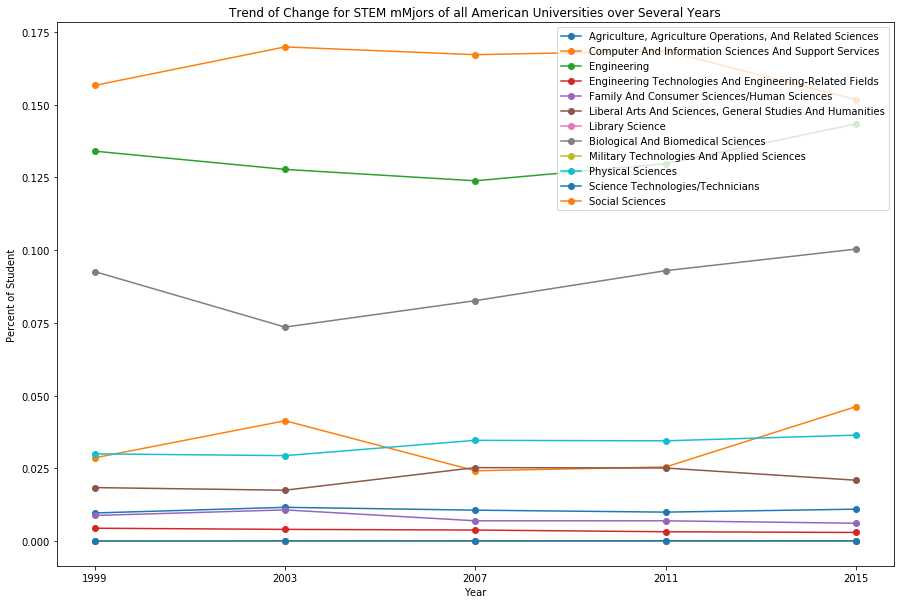

In [12]:
# Here we will plot all the change for STEM majors between year 1999 to year 2015 to see the trend of people's choice
plt.figure(figsize=(15,10))
plt.title('Trend of Change for STEM mMjors of all American Universities over Several Years')
PCIP01 = plt.plot(df['Year'], df['PCIP01'], '-o', label=col_dict.get('PCIP01'))
PCIP11 = plt.plot(df['Year'], df['PCIP11'], '-o', label=col_dict.get('PCIP11'))
PCIP14 = plt.plot(df['Year'], df['PCIP14'], '-o', label=col_dict.get('PCIP14'))
PCIP15 = plt.plot(df['Year'], df['PCIP15'], '-o', label=col_dict.get('PCIP15'))
PCIP19 = plt.plot(df['Year'], df['PCIP19'], '-o', label=col_dict.get('PCIP19'))
PCIP24 = plt.plot(df['Year'], df['PCIP24'], '-o', label=col_dict.get('PCIP24'))
PCIP25 = plt.plot(df['Year'], df['PCIP25'], '-o', label=col_dict.get('PCIP25'))
PCIP26 = plt.plot(df['Year'], df['PCIP26'], '-o', label=col_dict.get('PCIP26'))
PCIP29 = plt.plot(df['Year'], df['PCIP29'], '-o', label=col_dict.get('PCIP29'))
PCIP40 = plt.plot(df['Year'], df['PCIP40'], '-o', label=col_dict.get('PCIP40'))
PCIP41 = plt.plot(df['Year'], df['PCIP41'], '-o', label=col_dict.get('PCIP41'))
PCIP45 = plt.plot(df['Year'], df['PCIP45'], '-o', label=col_dict.get('PCIP45'))
plt.ylabel('Percent of Student')
plt.xlabel('Year')
pylab.legend(loc='upper right')

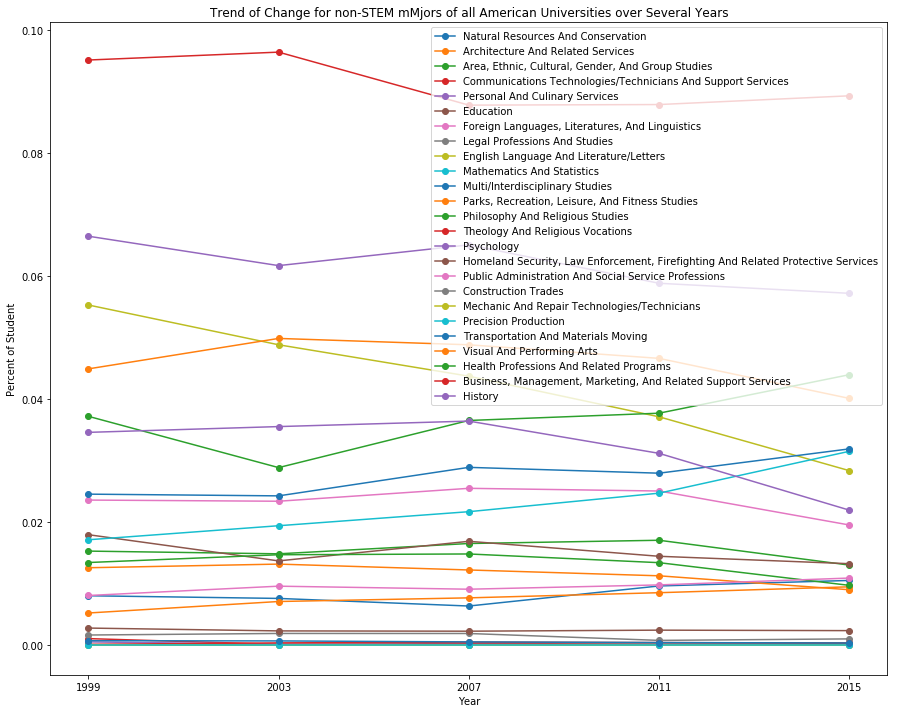

In [13]:
# Here we will plot all the change for non-STEM majors between year 1999 to year 2015 to see the trend of 
#people's choice
plt.figure(figsize=(15,12))
plt.title('Trend of Change for non-STEM mMjors of all American Universities over Several Years')
PCIP03 = plt.plot(df['Year'], df['PCIP03'], '-o', label=col_dict.get('PCIP03'))
PCIP04 = plt.plot(df['Year'], df['PCIP04'], '-o', label=col_dict.get('PCIP04'))
PCIP05 = plt.plot(df['Year'], df['PCIP05'], '-o', label=col_dict.get('PCIP05'))
PCIP10 = plt.plot(df['Year'], df['PCIP10'], '-o', label=col_dict.get('PCIP10'))
PCIP12 = plt.plot(df['Year'], df['PCIP12'], '-o', label=col_dict.get('PCIP12'))
PCIP13 = plt.plot(df['Year'], df['PCIP13'], '-o', label=col_dict.get('PCIP13'))
PCIP16 = plt.plot(df['Year'], df['PCIP16'], '-o', label=col_dict.get('PCIP16'))
PCIP22 = plt.plot(df['Year'], df['PCIP22'], '-o', label=col_dict.get('PCIP22'))
PCIP23 = plt.plot(df['Year'], df['PCIP23'], '-o', label=col_dict.get('PCIP23'))
PCIP27 = plt.plot(df['Year'], df['PCIP27'], '-o', label=col_dict.get('PCIP27'))
PCIP30 = plt.plot(df['Year'], df['PCIP30'], '-o', label=col_dict.get('PCIP30'))
PCIP31 = plt.plot(df['Year'], df['PCIP31'], '-o', label=col_dict.get('PCIP31'))
PCIP38 = plt.plot(df['Year'], df['PCIP38'], '-o', label=col_dict.get('PCIP38'))
PCIP39 = plt.plot(df['Year'], df['PCIP39'], '-o', label=col_dict.get('PCIP39'))
PCIP42 = plt.plot(df['Year'], df['PCIP42'], '-o', label=col_dict.get('PCIP42'))
PCIP43 = plt.plot(df['Year'], df['PCIP43'], '-o', label=col_dict.get('PCIP43'))
PCIP44 = plt.plot(df['Year'], df['PCIP44'], '-o', label=col_dict.get('PCIP44'))
PCIP46 = plt.plot(df['Year'], df['PCIP46'], '-o', label=col_dict.get('PCIP46'))
PCIP47 = plt.plot(df['Year'], df['PCIP47'], '-o', label=col_dict.get('PCIP47'))
PCIP48 = plt.plot(df['Year'], df['PCIP48'], '-o', label=col_dict.get('PCIP48'))
PCIP49 = plt.plot(df['Year'], df['PCIP49'], '-o', label=col_dict.get('PCIP49'))
PCIP50 = plt.plot(df['Year'], df['PCIP50'], '-o', label=col_dict.get('PCIP50'))
PCIP51 = plt.plot(df['Year'], df['PCIP51'], '-o', label=col_dict.get('PCIP51'))
PCIP52 = plt.plot(df['Year'], df['PCIP52'], '-o', label=col_dict.get('PCIP52'))
PCIP54 = plt.plot(df['Year'], df['PCIP54'], '-o', label=col_dict.get('PCIP54'))
plt.ylabel('Percent of Student')
plt.xlabel('Year')
pylab.legend(loc='upper right')

From the above connected scatter plot graph, we can see that the trend is not very obvious as we have expected that 

most of STEM major will gain an incresing percentage of student enrolled. Instead, what is shown above is that most 

of majors stayed unchanged for those several years where we collected data from and there is no brust on more student

choosing STEM majors.

### README ###
How to use the dataset: 
1. just print the df and you can see the format.
2. column names have names 'PCIP' + number. (which is a bit confusing)
3. To make things easier, I created a python dictionary called 'col_dic' that takes input the column names and outputs the major name
   
   Ex: col_dict['PCIP01'] returns the string "Agriculture, Agriculture Operations, And Related Sciences"
   
   (You can print col_dict to see its contents)


## Data 2: Salary payout by Major

This dataset is listed on a website that shows a ranking of potential salary payout based on major.

We will use webscraping to retrieve this information.

For webscraping we require request and BeautifulSoup

In [14]:
import requests
import bs4
from bs4 import BeautifulSoup

In [15]:
DATA2_URL = 'https://www.payscale.com/college-salary-report/majors-that-pay-you-back/bachelors?page=33'
page = requests.get(DATA2_URL)
soup = BeautifulSoup(page.content, 'html.parser')

In [16]:
import re
p = re.compile('var collegeSalaryReportData = (.*);')   

for script in soup.find_all("script", {"src":False}):
    if script:
        m = p.search(str(script.string))
        if (m):
            data = m
            break
        
# pd.read_json(data.group(1))
df2 = pd.read_json(data.group(1))
df2.drop(columns=['Url'], inplace=True)
df2

,% High Job Meaning,0-5 Years Experience,10-20 Years Experience,20+ Years Experience,5-10 Years Experience,Degree Type,Early Career Median Pay,Major,Mid-Career Median Pay,Rank,Tie
0,0.65,94600,152800,199200,135800,Bachelor's,94600,Petroleum Engineering,175500,1,NaN
1,0.49,56400,133300,N/A,86100,Bachelor's,56400,Actuarial Mathematics,131700,2,NaN
2,0.43,61200,129500,138500,95800,Bachelor's,61200,Actuarial Science,130800,3,NaN
3,0.72,69000,117000,132900,92400,Bachelor's,69000,Nuclear Engineering,127500,4,NaN
4,0.57,70300,113600,139500,90900,Bachelor's,70300,Chemical Engineering,124500,5,NaN
5,0.68,73900,110100,144700,85900,Bachelor's,73900,Marine Engineering,123200,6,NaN
6,0.36,60000,114700,N/A,90400,Bachelor's,60000,Economics and Mathematics,122900,7,NaN
7,N/A,54100,99900,N/A,N/A,Bachelor's,54100,Geophysics,122200,8,NaN
8,0.4,54000,117700,N/A,89800,Bachelor's,54000,Cognitive Science,121900,9,NaN
9,0.7,68600,N/A,127900,94500,Bachelor's,68600,Electrical Power Engineering,119100,10,NaN


The data above shows average expected payout for each major after graduation and shows the average salary as time goes on. At first glance, the first 10 highest payout jobs are mostly Engineering, which are subset in STEM majors.

### Data 2: Salary payout by Major

Text(0.5,1,'Top 500 Majors distribution of Early Career Median Pay')

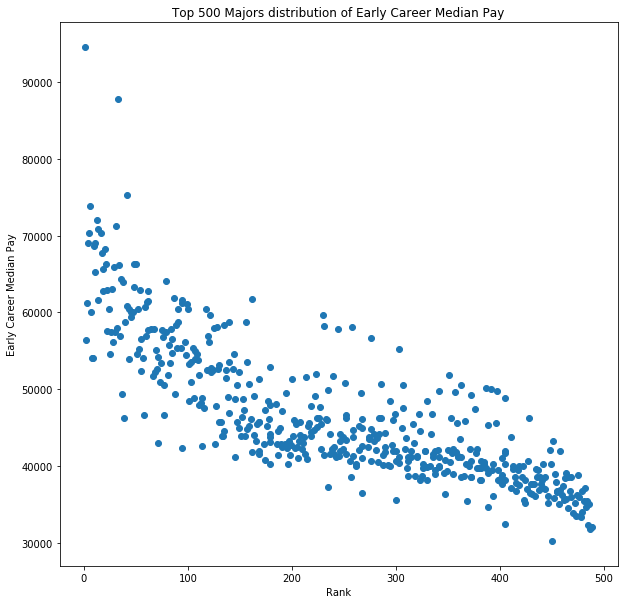

In [17]:
all_compound_df = df2[['Rank', 'Early Career Median Pay']]
plt.figure(figsize=(10,10))
plt.scatter(all_compound_df['Rank'], df2['Early Career Median Pay'])
plt.ylabel('Early Career Median Pay')
plt.xlabel('Rank')
plt.title('Top 500 Majors distribution of Early Career Median Pay')

Text(0.5,1,'Top 500 Majors distribution of Mid-Career Median Pay')

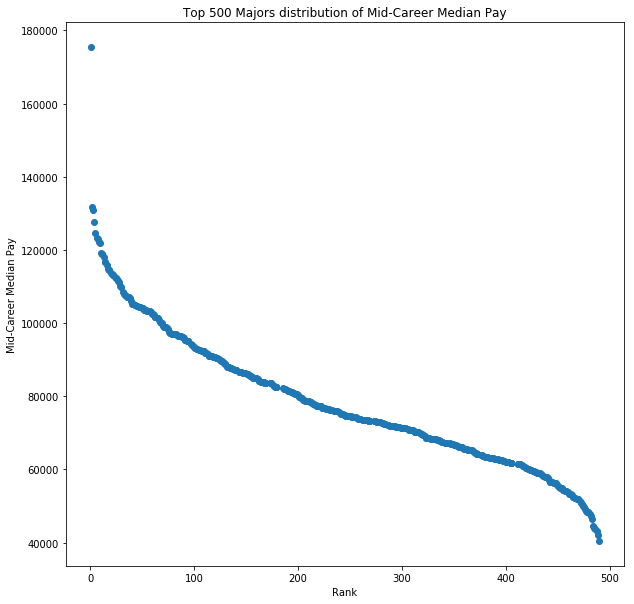

In [18]:
all_compound_df = df2[['Rank', 'Mid-Career Median Pay']]
plt.figure(figsize=(10,10))
plt.scatter(all_compound_df['Rank'], df2['Mid-Career Median Pay'])
plt.ylabel('Mid-Career Median Pay')
plt.xlabel('Rank')
plt.title('Top 500 Majors distribution of Mid-Career Median Pay')

Text(0.5,1,'Top 500 Majors distribution of 0-5 Years Experience Pay')

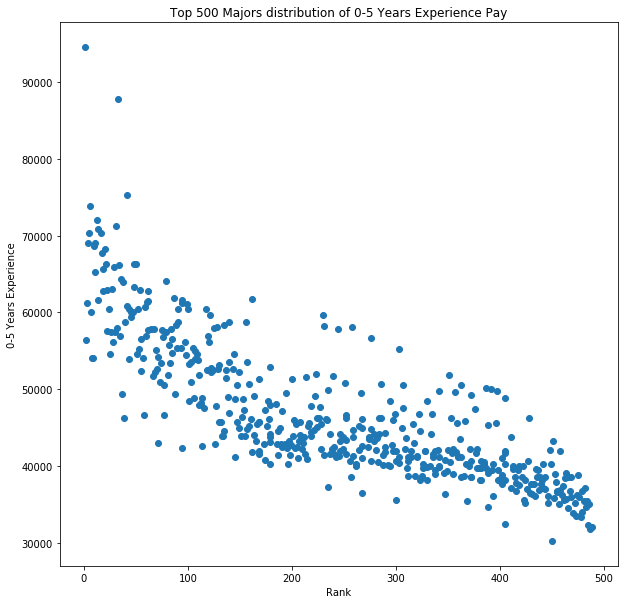

In [19]:
all_compound_df = df2[['Rank', '0-5 Years Experience']]
plt.figure(figsize=(10,10))
plt.scatter(all_compound_df['Rank'], df2['0-5 Years Experience'])
plt.ylabel('0-5 Years Experience')
plt.xlabel('Rank')
plt.title('Top 500 Majors distribution of 0-5 Years Experience Pay')

In this section, we will perform some basic data analysis to find the association between major that people choose in

universities and the salaries they receive after graduation for certain years

In [20]:
# Here we can define a function to briefly proform some simple substring checking in order to group STEM major and 
# those un-STEM major together
def standarize_major(string):
    
    string = string.lower()
    string = string.strip()
    
    if 'science' in string:
        result = 'STEM'
    elif 'engineering' in string:
        result = 'STEM'
    elif 'engineer' in string:
        result = 'STEM'
    elif 'math' in string:
        result = 'STEM'
    elif 'mathmatics' in string:
        result = 'STEM'
    elif 'technology' in string:
        result = 'STEM'
    else:
        result = 'non-STEM'
    
    return result

In [21]:
df2['Major'] = df2['Major'].apply(standarize_major)
df2.head(10)

,% High Job Meaning,0-5 Years Experience,10-20 Years Experience,20+ Years Experience,5-10 Years Experience,Degree Type,Early Career Median Pay,Major,Mid-Career Median Pay,Rank,Tie
0,0.65,94600,152800,199200,135800,Bachelor's,94600,STEM,175500,1,NaN
1,0.49,56400,133300,N/A,86100,Bachelor's,56400,STEM,131700,2,NaN
2,0.43,61200,129500,138500,95800,Bachelor's,61200,STEM,130800,3,NaN
3,0.72,69000,117000,132900,92400,Bachelor's,69000,STEM,127500,4,NaN
4,0.57,70300,113600,139500,90900,Bachelor's,70300,STEM,124500,5,NaN
5,0.68,73900,110100,144700,85900,Bachelor's,73900,STEM,123200,6,NaN
6,0.36,60000,114700,N/A,90400,Bachelor's,60000,STEM,122900,7,NaN
7,N/A,54100,99900,N/A,N/A,Bachelor's,54100,non-STEM,122200,8,NaN
8,0.4,54000,117700,N/A,89800,Bachelor's,54000,STEM,121900,9,NaN
9,0.7,68600,N/A,127900,94500,Bachelor's,68600,STEM,119100,10,NaN


In [22]:
desc = df2.describe()
desc

,0-5 Years Experience,Early Career Median Pay,Mid-Career Median Pay,Rank
count,489.000000,489.000000,489.000000,489.000000
mean,46648.261759,46648.261759,78426.175869,244.586912
std,9167.505540,9167.505540,18362.265574,141.243051
min,30200.000000,30200.000000,40400.000000,1.000000
25%,40200.000000,40200.000000,65200.000000,122.000000
50%,43900.000000,43900.000000,74800.000000,245.000000
75%,52300.000000,52300.000000,90400.000000,367.000000
max,94600.000000,94600.000000,175500.000000,489.000000


Here we will pull out the data we need for analysis. Specifically, we will compare the distribution of STEM majors

and non-STEM majors from the dataframe we have generated above

In [23]:
# Generate seperate data for STEM and non-STEM major salaries when in early and mid career period
salary_STEM_early = df2[df2['Major'] == 'STEM']['Early Career Median Pay'].values
salary_STEM_mid = df2[df2['Major'] == 'STEM']['Mid-Career Median Pay'].values
salary_NON_STEM_early = df2[df2['Major'] == 'non-STEM']['Early Career Median Pay'].values
salary_NON_STEM_mid = df2[df2['Major'] == 'non-STEM']['Mid-Career Median Pay'].values

In [24]:
# Print out the basic information comparing STEM and non-STEM majors
print("The EARLY average salary for those graduate from STEM majors is", salary_STEM_early.mean())
print("The EARLY average salary fot those graduate from non-STEM majors is", salary_NON_STEM_early.mean())
print("The MID average salary for those graduate from STEM majors is", salary_STEM_mid.mean())
print("The MID average salary for those graduate from non-STEM majors is", salary_NON_STEM_mid.mean())

The EARLY average salary for those graduate from STEM majors is 54516.93548387097
The EARLY average salary fot those graduate from non-STEM majors is 43975.068493150684
The MID average salary for those graduate from STEM majors is 91172.58064516129
The MID average salary for those graduate from non-STEM majors is 74095.8904109589
